## Ciencia de datos

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import keras
import matplotlib.pyplot as plt

2024-10-17 00:57:41.015828: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
# Set the environment flag for determinism
tf.config.experimental.enable_op_determinism()

In [3]:
data = pd.read_csv("../data/productividad_limpio.csv")


In [56]:
data["idle_men"].unique()

array([ 0, 10, 15, 45, 37, 30, 35, 20, 25, 40])

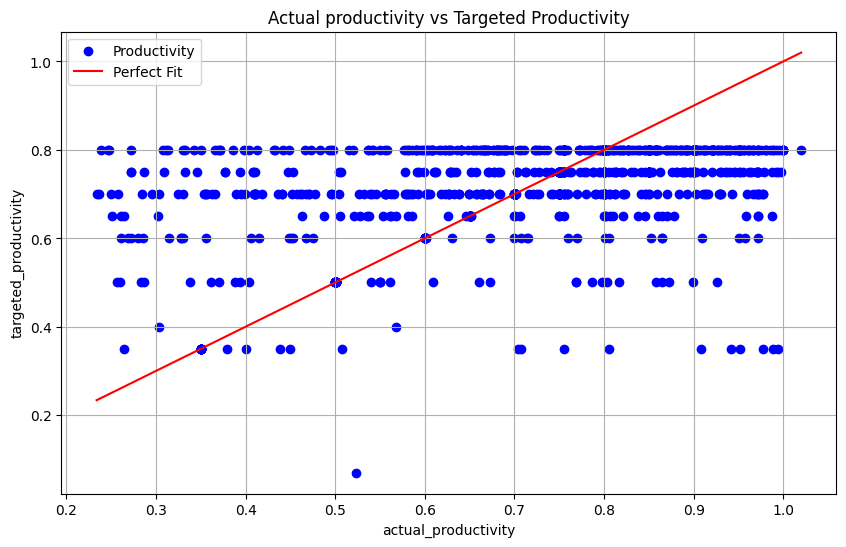

In [4]:
# Make predictions on the test set
y_pred_prod=data['targeted_productivity']
y_real_prod=data['actual_productivity']

# Plot Predicted vs True values
plt.figure(figsize=(10,6))
plt.scatter(y_real_prod, y_pred_prod, color='blue', label='Productivity')
plt.plot([min(y_real_prod), max(y_real_prod)], [min(y_real_prod), max(y_real_prod)], color='red', label='Perfect Fit')
plt.xlabel('actual_productivity')
plt.ylabel('targeted_productivity')
plt.title('Actual productivity vs Targeted Productivity')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
data = data.drop(columns=['date','targeted_productivity','team'], axis=1)
data.head()

,quarter,department,day,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,Quarter1,sweing,Thursday,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,Quarter1,finishing,Thursday,3.94,1039.0,960,0,0.0,0,0,8.0,0.886500
2,Quarter1,sweing,Thursday,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,Quarter1,sweing,Thursday,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,Quarter1,sweing,Thursday,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [6]:
data.dtypes

quarter                 object
department              object
day                     object
smv                    float64
wip                    float64
over_time                int64
incentive                int64
idle_time              float64
idle_men                 int64
no_of_style_change       int64
no_of_workers          float64
actual_productivity    float64
dtype: object

In [7]:
data.columns

Index(['quarter', 'department', 'day', 'smv', 'wip', 'over_time', 'incentive',
       'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers',
       'actual_productivity'],
      dtype='object')

In [8]:
data.shape

(1197, 12)

In [9]:
target= 'actual_productivity'
cat_str_feats = ["quarter","department","day"]
cat_int_feats = []#["team"]
cat_cols=cat_str_feats+cat_int_feats
num_cols=[x for x in data.columns if x not in cat_cols and x not in [target] ]


In [10]:
feats_ordered= cat_cols+num_cols

In [11]:
feats_ordered

['quarter',
 'department',
 'day',
 'smv',
 'wip',
 'over_time',
 'incentive',
 'idle_time',
 'idle_men',
 'no_of_style_change',
 'no_of_workers']

In [12]:
df = data[feats_ordered+[target]]
df.head()

,quarter,department,day,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,Quarter1,sweing,Thursday,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,Quarter1,finishing,Thursday,3.94,1039.0,960,0,0.0,0,0,8.0,0.886500
2,Quarter1,sweing,Thursday,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,Quarter1,sweing,Thursday,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,Quarter1,sweing,Thursday,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [13]:
df_train=  df.sample(frac=0.8, random_state=100)

In [14]:
df_test = df.drop(df_train.index)


In [15]:
df_val = df_train.sample(frac=0.2, random_state=100)

In [16]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)
print(df.shape)

(958, 12)
(192, 12)
(239, 12)
(1197, 12)


In [17]:
#Función para convertir de dataframe (pandas) a dataset (tensorflow), separando características y etiquetas
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop(target)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [18]:
train_ds = dataframe_to_dataset(df_train)
val_ds = dataframe_to_dataset(df_val)
test_ds = dataframe_to_dataset(df_test)

In [19]:
#Ejemplo de cómo queda el tf.dataset
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'quarter': <tf.Tensor: shape=(), dtype=string, numpy=b'Quarter1'>, 'department': <tf.Tensor: shape=(), dtype=string, numpy=b'sweing'>, 'day': <tf.Tensor: shape=(), dtype=string, numpy=b'Tuesday'>, 'smv': <tf.Tensor: shape=(), dtype=float64, numpy=15.26>, 'wip': <tf.Tensor: shape=(), dtype=float64, numpy=983.0>, 'over_time': <tf.Tensor: shape=(), dtype=int64, numpy=4080>, 'incentive': <tf.Tensor: shape=(), dtype=int64, numpy=50>, 'idle_time': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'idle_men': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'no_of_style_change': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'no_of_workers': <tf.Tensor: shape=(), dtype=float64, numpy=34.0>}
Target: tf.Tensor(0.800401961, shape=(), dtype=float64)


In [20]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [21]:
# Función para codificar variables numéricas (Keras docs)
def encode_numerical_feature(feature, name, dataset):
    # Crea capa de normalización para este feature
    normalizer = keras.layers.Normalization()

    # Prepara el dataset para considerar únicamente la feature de interés (name)
    feature_ds = dataset.map(lambda x, y: x[name]) # selecciona variable
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1)) # deja el tensor de una dimensión

    # Aprende las estadísticas de los datos (media, varianza)
    normalizer.adapt(feature_ds)

    # Aplica la normalización a la variable
    encoded_feature = normalizer(feature)
    return encoded_feature

# Función para codificar variables categóricas (Keras docs)
def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = keras.layers.StringLookup if is_string else keras.layers.IntegerLookup
    # Crea una capa Lookup para manejar la codificación one-hot o int
    lookup = lookup_class(output_mode="one_hot")

    # Prepara el dataset para considerar únicamente la feature de interés (name)
    feature_ds = dataset.map(lambda x, y: x[name]) # selecciona variable
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1)) # deja el tensor de una dimensión

    # Aprende el conjunto de posibles valores que toma la variable categórica y asigna enteros
    lookup.adapt(feature_ds)

    # Aplica la conversión de categorías a enteros
    encoded_feature = lookup(feature)
    return encoded_feature

In [22]:
inputs = []
for i in cat_int_feats:
  inputs.append(keras.Input(shape=(1,), name=i, dtype="int64"))

for i in cat_str_feats:
  inputs.append(keras.Input(shape=(1,), name=i, dtype="string"))

for i in num_cols:
  inputs.append(keras.Input(shape=(1,), name=i))

In [23]:
for i in inputs:
   print(i)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.string, name='quarter'), name='quarter', description="created by layer 'quarter'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.string, name='department'), name='department', description="created by layer 'department'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.string, name='day'), name='day', description="created by layer 'day'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='smv'), name='smv', description="created by layer 'smv'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='wip'), name='wip', description="created by layer 'wip'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='over_time'), name='over_time', description="created by layer 'over_time'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='incentive'), name='incentive', description="created by layer 'incentive'")
KerasTensor(type_

In [24]:
# Creamos una lista de variables codificadas/normalizadas de acuerdo con su tipo, empleando las funciones de codificación/normalización
feats_encoded=[]
for i,feat in enumerate(cat_int_feats):
  feats_encoded.append(
      encode_categorical_feature(inputs[i], feat, train_ds, False)
  )
len_feats = len(feats_encoded)

for i,feat in enumerate(cat_str_feats):
  feats_encoded.append(
      encode_categorical_feature(inputs[len_feats+i], feat, train_ds, True)
  )
len_feats = len(feats_encoded)

for i,feat in enumerate(num_cols):
  feats_encoded.append(
      encode_numerical_feature(inputs[len_feats+i], feat, train_ds)
  )
len_feats = len(feats_encoded)
print(len_feats)

11


In [25]:
for i in feats_encoded:
  print(i)

KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='string_lookup/bincount/DenseBincount:0', description="created by layer 'string_lookup'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), name='string_lookup_1/bincount/DenseBincount:0', description="created by layer 'string_lookup_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), name='string_lookup_2/bincount/DenseBincount:0', description="created by layer 'string_lookup_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization/truediv:0', description="created by layer 'normalization'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_1/truediv:0', description="created by layer 'normalization_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_2/truediv:0', description="created by layer

In [26]:
# Creamos una capa concatenando todas las variables codificadas
all_feats = keras.layers.concatenate(feats_encoded)
type(all_feats)

keras.src.engine.keras_tensor.KerasTensor

# Modelo con redes neuronales 

In [27]:

model_layers = keras.layers.Dense(64, activation='relu')(all_feats)
# Creamos una capa de salida sigmoide ya que nuestra target es una probabilidad 
model_layers = keras.layers.Dense(1, activation='sigmoid')(model_layers)
model_nn = keras.Model(inputs, model_layers)

In [28]:
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# # Add hidden layers
# model_layers = Dense(128, activation='relu')(all_feats)
# model_layers = BatchNormalization()(model_layers)
# model_layers = Dropout(0.3)(model_layers)

# model_layers = Dense(64, activation='relu')(model_layers)
# model_layers = BatchNormalization()(model_layers)
# model_layers = Dropout(0.3)(model_layers)

# model_layers = Dense(32, activation='relu')(model_layers)

# # Output layer
# output = Dense(1, activation='sigmoid')(model_layers)

# # Build the model
# model_nn = keras.Model(inputs, outputs=output)

In [29]:
def r_squared(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

# Recompile the model to include the custom R² metric
model_nn.compile(
    optimizer='adam', 
    # loss='mean_absolute_error',
    loss='mean_squared_error',  # Use MSE loss for regression
    metrics=[
        tf.keras.metrics.MeanSquaredError(name='mse'),  # MSE metric
        tf.keras.metrics.MeanAbsoluteError(name='mae'),  # MAE metric
        r_squared  # Custom R² metric
    ]
)

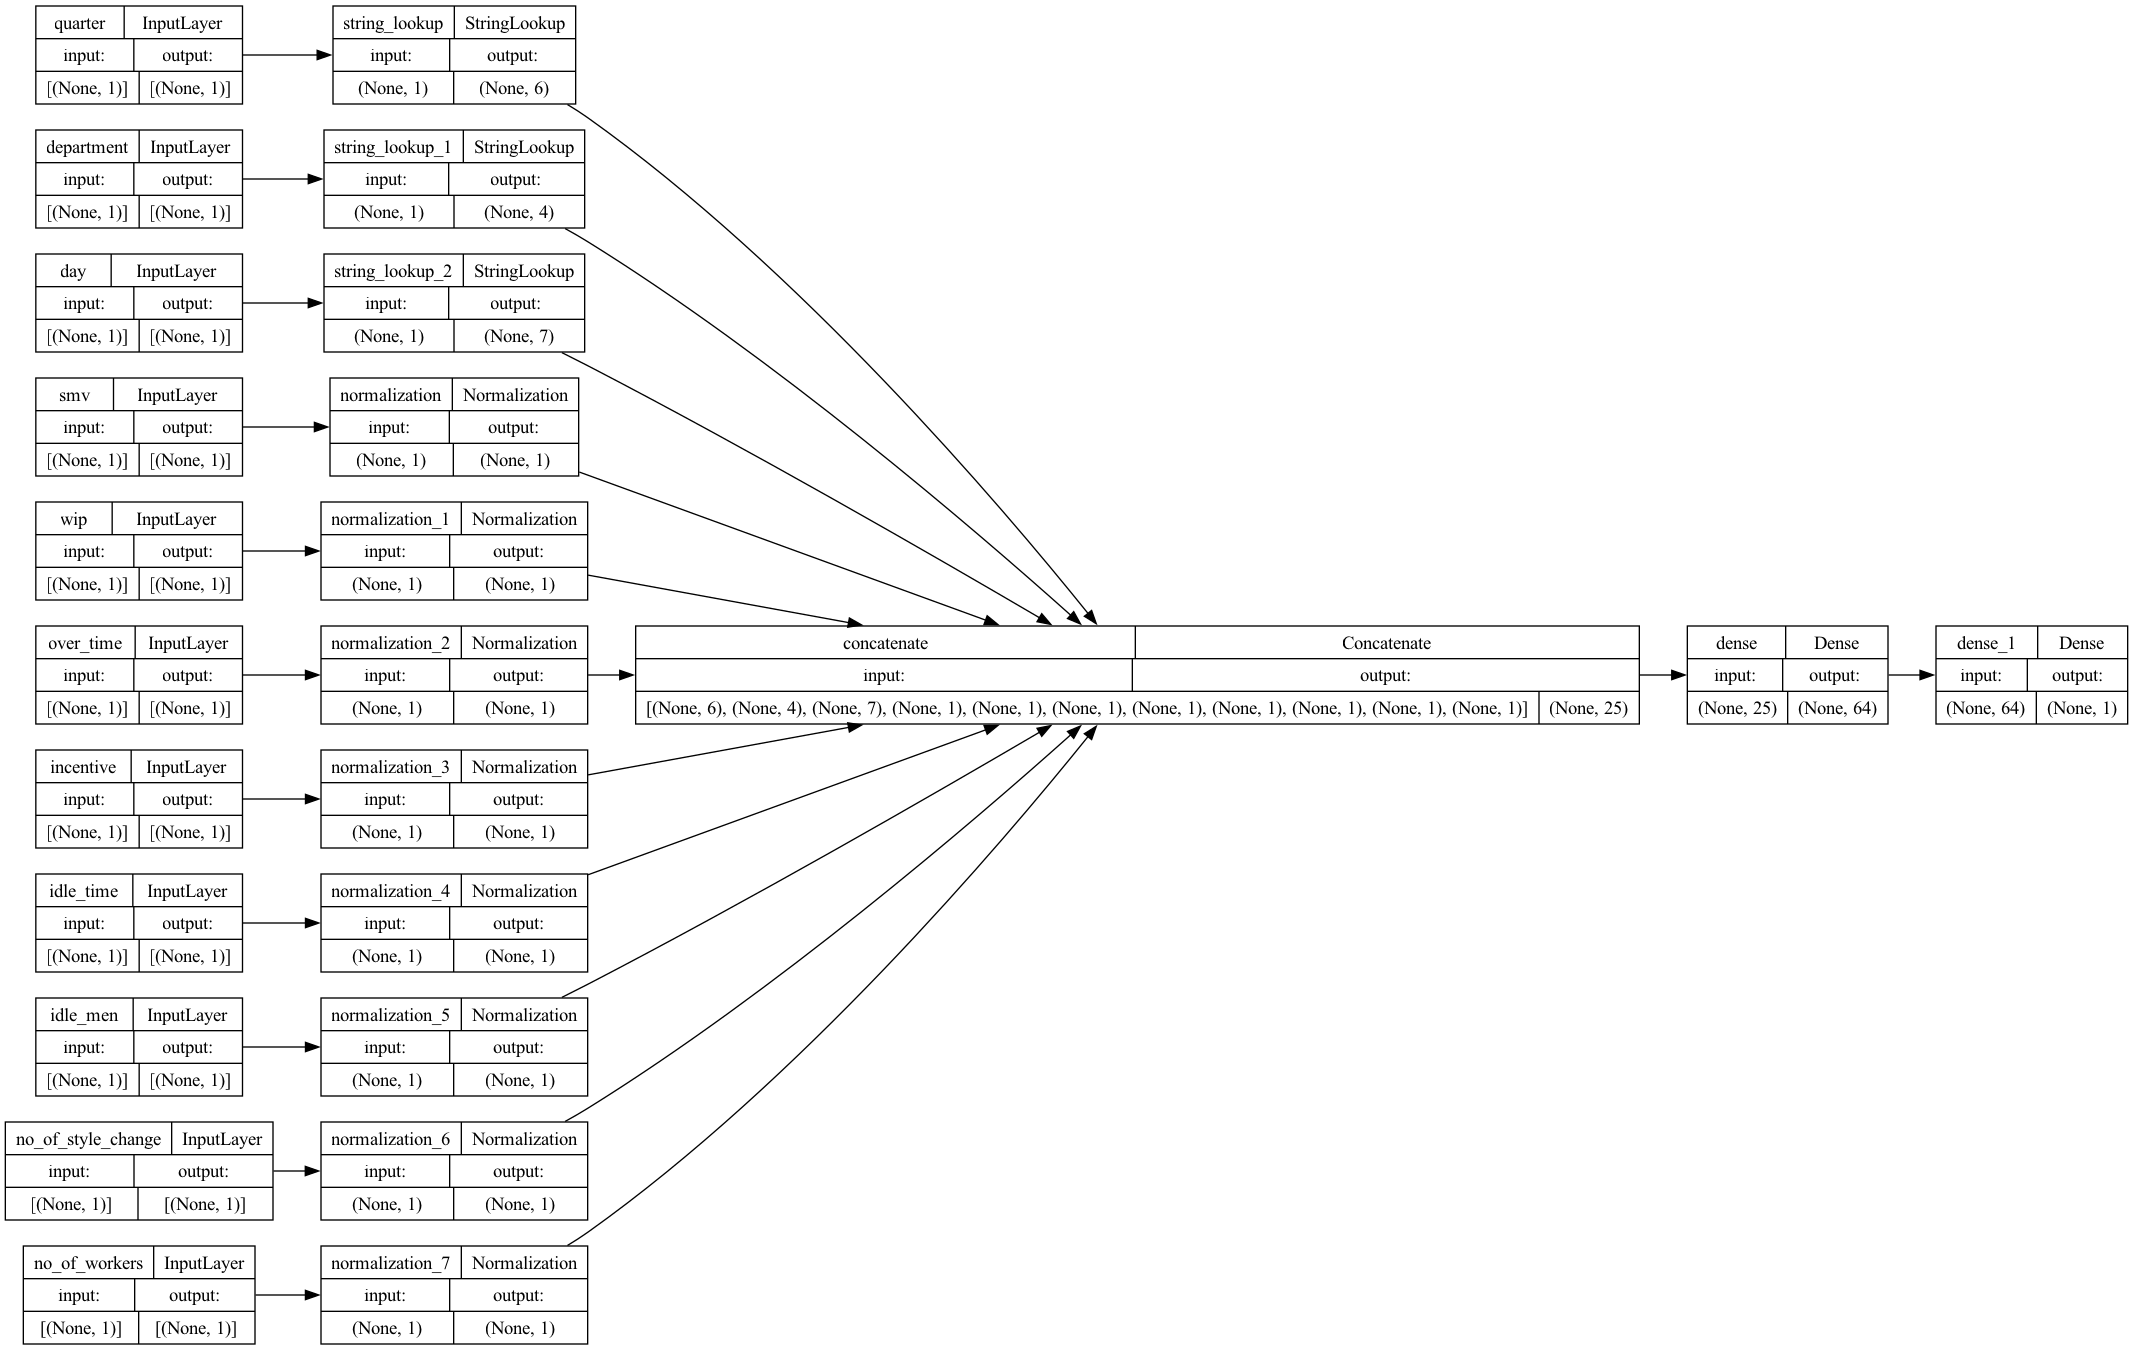

In [30]:
keras.utils.plot_model(model_nn, show_shapes=True, rankdir="LR")

In [31]:
history_nn = model_nn.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
30/30 [==============================] - 2s 16ms/step - loss: 0.1134 - mse: 0.1134 - mae: 0.3007 - r_squared: -3.6406 - val_loss: 0.0570 - val_mse: 0.0570 - val_mae: 0.2110 - val_r_squared: -1.0878
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0397 - mse: 0.0397 - mae: 0.1701 - r_squared: -0.5105 - val_loss: 0.0325 - val_mse: 0.0325 - val_mae: 0.1489 - val_r_squared: -0.1242
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0295 - mse: 0.0295 - mae: 0.1356 - r_squared: -0.1062 - val_loss: 0.0299 - val_mse: 0.0299 - val_mae: 0.1373 - val_r_squared: -0.0852
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0274 - mse: 0.0274 - mae: 0.1292 - r_squared: -0.0319 - val_loss: 0.0282 - val_mse: 0.0282 - val_mae: 0.1350 - val_r_squared: 0.0284
Epoch 5/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0259 - mse: 0.0259 - mae: 0.1250 - r_squared: 0.0274 - val_loss: 0.0272 - val_mse: 0.0272 - va

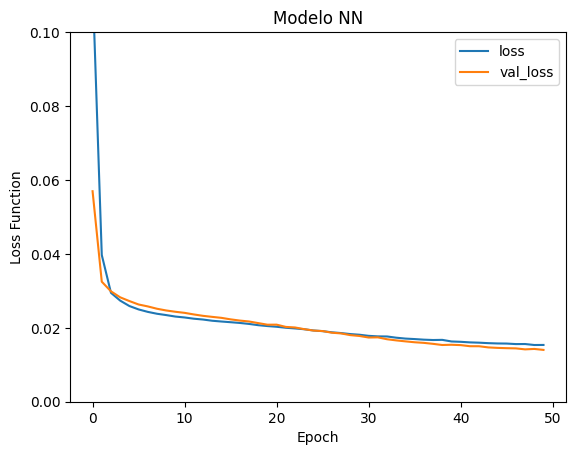

In [32]:

plt.plot(history_nn.history['loss'], label='loss')
plt.plot(history_nn.history['val_loss'], label='val_loss')
plt.ylim([0, 0.1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Modelo NN")
plt.legend()

In [33]:
results_nn = model_nn.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados para modelo experimento 5")
for name, value in zip(model_nn.metrics_names, results_nn):
    print(f"{name}: {value}")



Resultados para modelo experimento 5
loss: 0.024538608267903328
mse: 0.024538608267903328
mae: 0.10960986465215683
r_squared: 0.06799706071615219


In [34]:
# Optimizing  MSE
# Resultados para modelo experimento 5
# loss: 0.02206740528345108
# mse: 0.02206740528345108
# mae: 0.09872309118509293
# r_squared: 0.167173370718956

In [35]:
# Make predictions on the test set
y_pred = model_nn.predict(test_ds)
y_test=df_test[target]

8/8 [==============================] - 0s 2ms/step


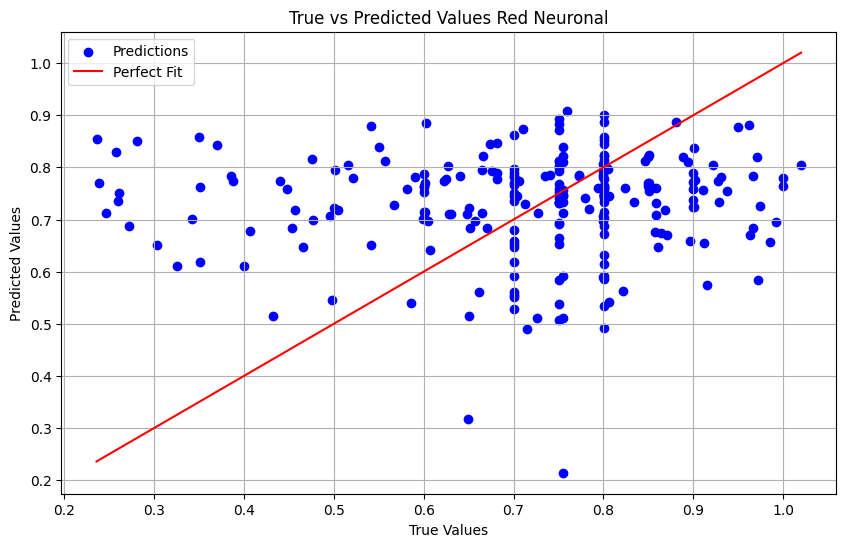

In [36]:

# Plot Predicted vs True values
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Perfect Fit')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values Red Neuronal')
plt.legend()
plt.grid(True)
plt.show()


# Regresion Lineal

# Regresion con solo variables numericas

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm

In [38]:
exclude_cols=["wip","over_time","incentive","idle_time","team"]
feats_ordered= [x for x in feats_ordered if x not in exclude_cols]
num_cols= [x for x in num_cols if x not in exclude_cols]

In [39]:
X_train, X_test, y_train, y_test = df_train[num_cols] , df_test[num_cols], df_train[target],df_test[target]

In [40]:
# from sklearn.preprocessing import StandardScaler

# # Define the column transformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', 'passthrough', num_cols),  # Leave numerical columns as is
#         ('cat', OneHotEncoder(), cat_cols)  # OneHotEncode categorical features
#     ])

# # Transform the training and test sets
# X_train_encoded = preprocessor.fit_transform(X_train)
# X_test_encoded = preprocessor.transform(X_test)

# # Check transformed feature matrix
# print(X_train_encoded)

In [41]:
# Fit the Linear Regression model
model = LinearRegression()
# model.fit(X_train_encoded, y_train)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)


In [42]:
# Calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')

MSE: 0.02784635085849109
MAE: 0.1224649698505783


In [43]:
# Add intercept to the encoded features (statsmodels requires it)
# X_train_encoded_sm = sm.add_constant(X_train_encoded)
X_train_sm = sm.add_constant(X_train)

# Fit an Ordinary Least Squares (OLS) model using statsmodels
# ols_model = sm.OLS(y_train, X_train_encoded_sm).fit()
ols_model = sm.OLS(y_train, X_train_sm).fit()

# Get the summary, including p-values
print(ols_model.summary())


                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.101
Model:                             OLS   Adj. R-squared:                  0.097
Method:                  Least Squares   F-statistic:                     26.63
Date:                 Thu, 17 Oct 2024   Prob (F-statistic):           5.80e-21
Time:                         00:58:00   Log-Likelihood:                 408.18
No. Observations:                  958   AIC:                            -806.4
Df Residuals:                      953   BIC:                            -782.0
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.7

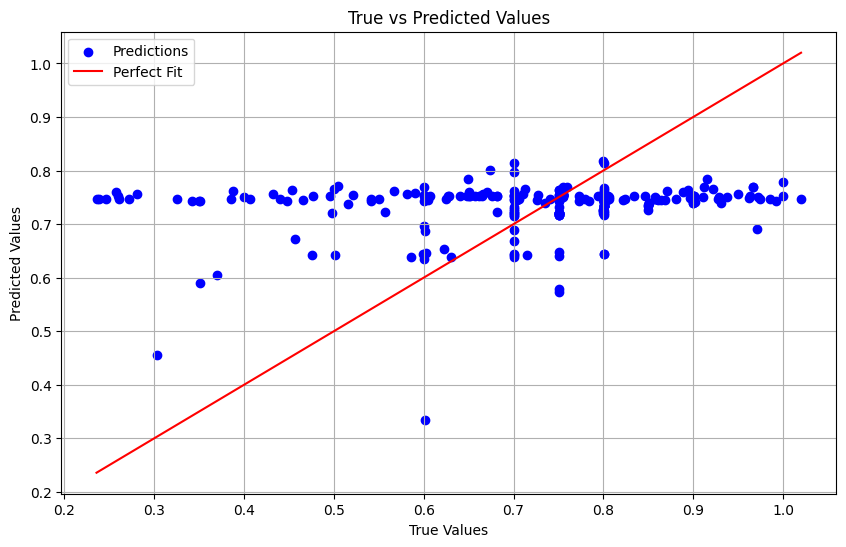

In [44]:
# Make predictions on the test set
y_test=df_test[target]

# Plot Predicted vs True values
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Perfect Fit')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


# Modelo con todas las variables y usando encoder

In [45]:
exclude_cols=["wip","over_time","incentive","idle_time","team"]
feats_ordered= [x for x in feats_ordered if x not in exclude_cols]
num_cols= [x for x in num_cols if x not in exclude_cols]

In [46]:
X_train, X_test, y_train, y_test = df_train[feats_ordered] , df_test[feats_ordered], df_train[target],df_test[target]

In [47]:
from sklearn.preprocessing import StandardScaler

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),  # Leave numerical columns as is
        ('cat', OneHotEncoder(), cat_cols)  # OneHotEncode categorical features
    ])

# Transform the training and test sets
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Get the column names for the numerical columns
num_feature_names = num_cols

# Get the column names for the one-hot encoded categorical features
ohe = OneHotEncoder()
ohe.fit(X_train[cat_cols])
cat_feature_names = ohe.get_feature_names_out(cat_cols)

# Combine the numerical and categorical feature names
all_feature_names = list(num_feature_names) + list(cat_feature_names)

# Convert the transformed numpy array to a DataFrame with column names
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=all_feature_names)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=all_feature_names)


In [48]:
# Fit the Linear Regression model
model = LinearRegression()
model.fit(X_train_encoded_df, y_train)
# model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_encoded_df)


In [49]:
# Calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')

MSE: 0.028333400338378372
MAE: 0.12485938206271456


In [50]:
# Add intercept to the encoded features (statsmodels requires it)
X_train_encoded_sm = sm.add_constant(X_train_encoded_df)

y_train = y_train.reset_index(drop=True)
# Fit an Ordinary Least Squares (OLS) model using statsmodels
ols_model = sm.OLS(y_train, X_train_encoded_sm).fit()


# # Get the summary, including p-values
print(ols_model.summary())


                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.145
Model:                             OLS   Adj. R-squared:                  0.131
Method:                  Least Squares   F-statistic:                     10.65
Date:                 Thu, 17 Oct 2024   Prob (F-statistic):           4.66e-24
Time:                         00:58:01   Log-Likelihood:                 432.46
No. Observations:                  958   AIC:                            -832.9
Df Residuals:                      942   BIC:                            -755.1
Df Model:                           15                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

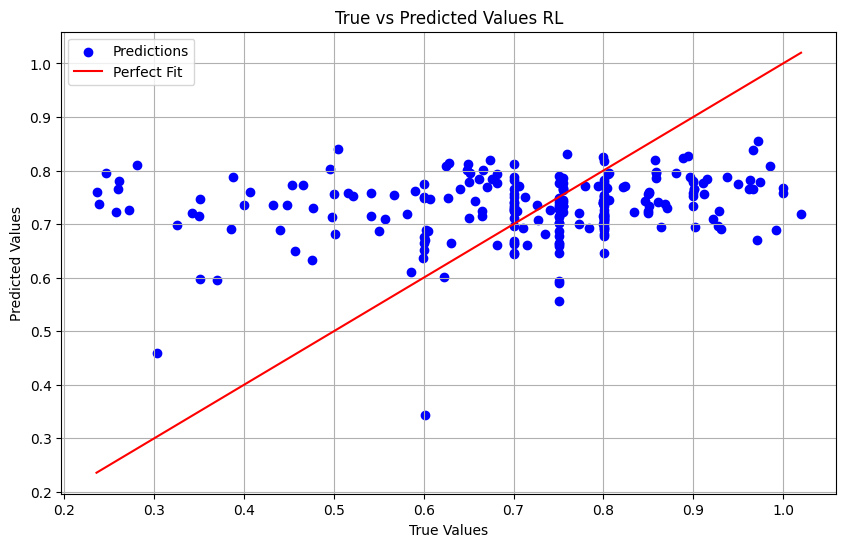

In [51]:
# Make predictions on the test set
y_test=df_test[target]

# Plot Predicted vs True values
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Perfect Fit')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values RL' )
plt.legend()
plt.grid(True)
plt.show()


Revisemos las variables categorias como interactuan con la variable de respuesta

<Axes: xlabel='quarter', ylabel='actual_productivity'>

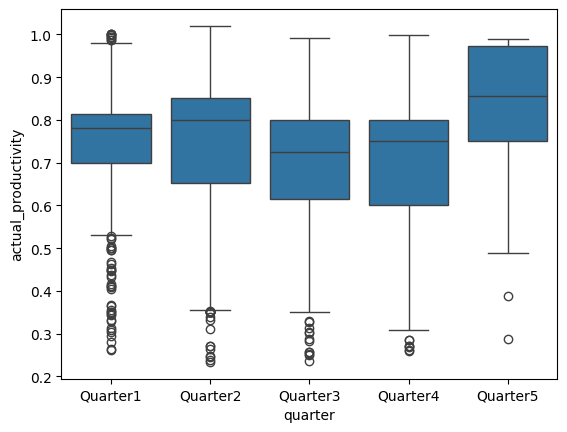

In [52]:
sns.boxplot(x='quarter', y=target, data=data)

<Axes: xlabel='department', ylabel='actual_productivity'>

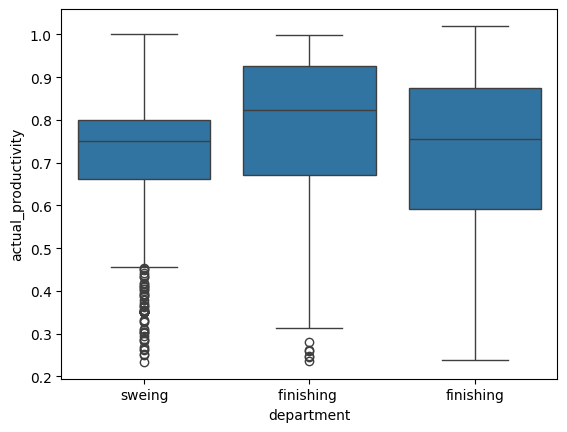

In [53]:
sns.boxplot(x='department', y=target, data=data)

<Axes: xlabel='department', ylabel='actual_productivity'>

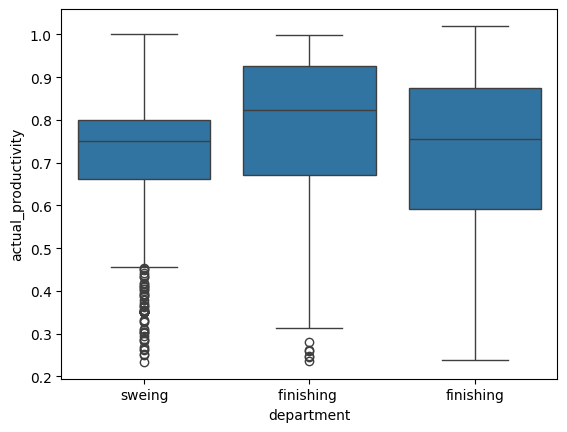

In [54]:
sns.boxplot(x='department', y=target, data=data)

<Axes: xlabel='day', ylabel='actual_productivity'>

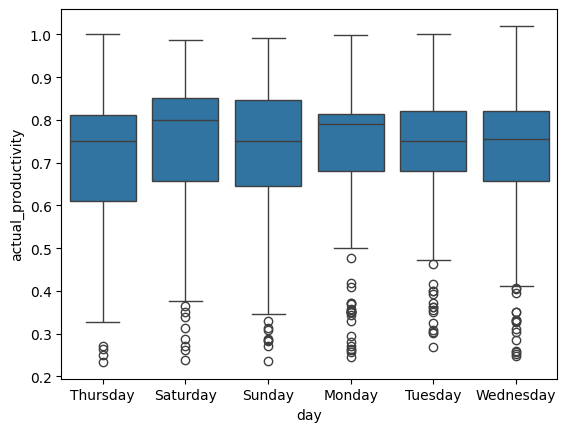

In [55]:
sns.boxplot(x='day', y=target, data=data)